# ML в Биологии
## 10. T-Tests

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm as tqdm
from scipy import integrate
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm as tqdm

sns.set_theme(font_scale=1.3, palette='Set2')
%matplotlib inline

## Задача 1

### **Профиль биология**

Рассмотрим данные об экспрессии белка DYRK1_A в мышах в разные дни. Загрузите датасет с сайта курса. Постройте гистограммы распределений и проведите t-test, чтобы выяснить, различается ли средний уровень экспрессии белка в день 1 и 2.

In [3]:
df = pd.read_csv('mice_expression.csv')
df.head()

,MouseID,Day 1,Day 2
0,309_1,0.503644,0.579893
1,309_2,0.514617,0.305341
2,309_3,0.509183,0.972346
3,309_4,0.442107,0.527091
4,309_5,0.434940,0.517172


 Построим гистограммы распределений:

array([<Axes: title={'center': 'Day 2'}>], dtype=object)

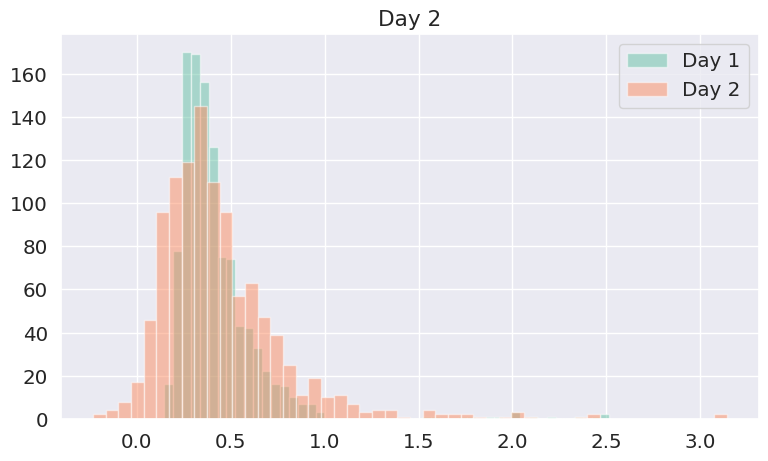

In [4]:
fig, ax = plt.subplots(figsize=(9, 5), ncols=1, nrows=1)
df.hist("Day 1", bins=50, ax=ax, legend=True, alpha=0.5)
df.hist("Day 2", bins=50, ax=ax, legend=True, alpha=0.5)

Проведем t-test:

In [5]:
sps.ttest_rel(df["Day 1"], df["Day 2"])

TtestResult(statistic=-2.1925908404058365, pvalue=0.028550423276649355, df=1076)

Объясните выбор теста и сделайте выводы.

**Вывод:**

Оба распределения в целом напоминают нормальные, поэтому можно использовать t-тест. Так как мы анализируем результаты на одних и тех же мышах, это зависимые выборки, поэтому применяем ttest_rel.

Полученное значение p-value меньше 0.05, значит, гипотеза о равенстве средних отклоняется.

## Задача 2


### **Профиль биология**


Рассмотрим [данные по медицинским страховкам](https://www.kaggle.com/datasets/gauravduttakiit/medical-insurance-cost?select=Train_Data.csv):

Скачайте файл с тренировочными данными и оставьте колонку:
* `charges` &mdash; стоимость страховки человека.

In [6]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: Sample_Submission.csv   
  inflating: Test_Data.csv           
  inflating: Train_Data.csv          


In [7]:
df = pd.read_csv('Train_Data.csv')
df.head()

,age,sex,bmi,smoker,region,children,charges
0,21.000000,male,25.745000,no,northeast,2,3279.868550
1,36.976978,female,25.744165,yes,southeast,3,21454.494239
2,18.000000,male,30.030000,no,southeast,1,1720.353700
3,37.000000,male,30.676891,no,northeast,3,6801.437542
4,58.000000,male,32.010000,no,southeast,1,11946.625900


Проведем дополнительный анализ:

In [8]:
data = df.charges
data.shape

(3630,)

<Axes: >

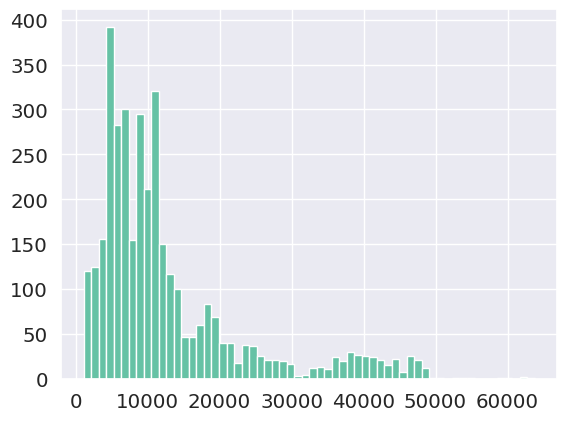

In [9]:
data.hist(bins=60)

In [10]:
data.describe()

,charges
count,3630.000000
mean,12784.808644
std,10746.166743
min,1121.873900
25%,5654.818262
50%,9443.807222
75%,14680.407505
max,63770.428010


**Вывод:**

Сразу отметим, что распределение данных здесь явно отличается от нормального, поэтому t-тест вряд ли покажет хорошие результаты.  

Также зафиксируем среднее и минимальное значения стоимости страховки.

Министерство здравоохранения хочет провести AB-тест для оценки значимости эффекта от новых рекомендаций по употреблению витаминов и использовать для этого t-test независимых выборок. Ожидается, что новые рекомендации повысят здоровье общества и снизят затраты на страховку. На время тестирования решено выдать рекомендации случайной группе из 1000 людей.

**1.**
Проведите 2000 случайных AA-тестов для проверки правильности работы t-test. Использовать нужно группы одинакого размера, конечно же, они не должны пересекаться.

In [11]:
n_iter = 5000
p_vals = []

for _ in tqdm(range(n_iter)):
    sample = np.random.choice(data.values, 2000, replace=False)

    inds1 = np.random.choice(np.arange(2000), 1000, replace=False)
    inds2 = list(set(np.arange(2000)) - set(list(inds1)))

    s1 = sample[inds1]
    s2 = sample[inds2]

    _, p_val = sps.ttest_ind(s1, s2)
    p_vals.append(p_val)

100%|██████████| 5000/5000 [00:14<00:00, 350.31it/s]


Вспомните, какое распределение имеет величина p-value в случае, если нулевая гипотеза верна?

**Ответ:**

Если нулевая гипотеза верна, то величина p-value имеет равномерное распределение на интервале $[0, 1]$. Это означает, что вероятность получения любого значения p-value внутри этого интервала одинакова.

Постройте гистограмму значений p-value. Корректно ли работает t-test на ваших данных?

Min p-value: 0.0002505927799932513


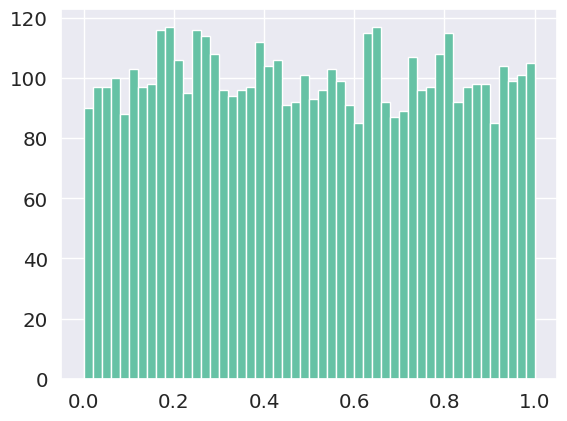

In [15]:
plt.hist(p_vals, bins=50);
print('Min p-value: ' + f'{min(p_vals)}')

**Вывод:**

t-тест не подходит для решения этой задачи, так как p-value имеют равномерное распределение. Это указывает на их случайный характер. Таким образом, использование t-теста для независимых выборок в данной задаче некорректно.

**2.** Зафиксируйте две выборки одинакового размера: контрольную и тестовую. С помощью проведения AB-теста выясните, какова мощность теста для разных значений эффекта. Схема проведения аналогична предыдущему пункту, но к тестовой группе нужно добавить отрицательное смещение.

При добавлении искусственного смещения рекомендуется также добавлять небольшой шум для каждого человека. Поясните, для чего это может быть полезно. Сделайте выводы.

In [16]:
n_iter = 2000
alpha = 0.05

# количество отвержений H_0
n_errors = []
shifts = np.linspace(0, 3000, 51)

for loc in tqdm(shifts):
    n_errors.append(0)
    for _ in range(n_iter):
        sample = np.random.choice(data.values, 2000, replace=False)

        inds1 = np.random.choice(np.arange(2000), 1000, replace=False)
        inds2 = list(set(np.arange(2000)) - set(list(inds1)))

        s1 = sample[inds1]
        s2 = sample[inds2]

        noise = sps.norm.rvs(size=1000) * 10

        x = s1
        y = s2 - loc + noise

        _, p_val = sps.ttest_ind(x, y)
        n_errors[-1] += p_val < alpha

100%|██████████| 51/51 [04:55<00:00,  5.80s/it]


Text(0, 0.5, 'Мощность')

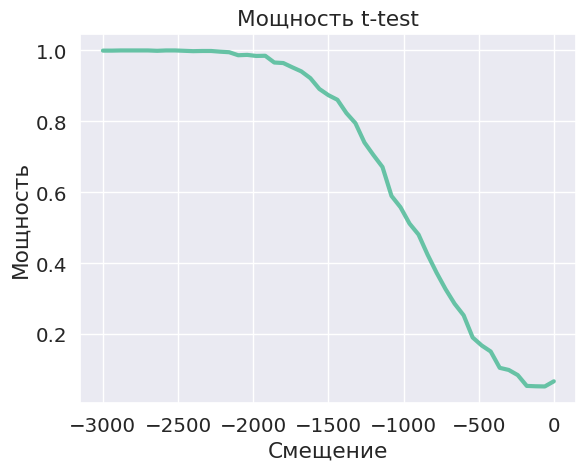

In [17]:
plt.plot(-shifts, np.array(n_errors)/n_iter, lw=3)

plt.title('Мощность t-test')
plt.xlabel('Смещение')
plt.ylabel('Мощность')

**Вывод:**

Мощность теста в целом показывает адекватное поведение.  

Она достигает значения 1 при отклонении около 2500, что составляет примерно 20% от среднего значения по выборке — это вполне неплохо.  

Однако минимальная стоимость страховки составляет 1122 единицы, поэтому для таких страховок тест может не обнаружить разницу. Цена не может стать отрицательной, максимум снизится на 5–10%. А для таких небольших изменений мощность остается низкой.

## Задача 3


### **Профиль биология**


Рассмотрим [данные о расстройствах сна](https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset?select=Sleep_health_and_lifestyle_dataset.csv):

Датасет содержит информацию об образе жизни людей, целевая переменная — есть ли у них расстройство сна.

С помощью методов дисперсионного анализа исследуйте, по каким параметрам наблюдается различие между двумя рассматриваемыми классами (теми, у кого есть расстройство сна, и теми, у кого нет). При возможности оцените также степень различия, в т.ч. доверительный интервал.

Скачайте файл и оставьте колонки:
* `Age` &mdash; возраст;
* `Sleep Duration` &mdash; длительность сна;
* `Physical Activity Level` &mdash; уровень физической активности;
* `Heart Rate` &mdash; ЧСС;
* `Daily Steps` &mdash; число пройденных шагов в день;
* `Sleep Disorder` &mdash; целевая переменная.

In [20]:
!unzip /content/archive_1.zip

Archive:  /content/archive_1.zip
  inflating: Sleep_health_and_lifestyle_dataset.csv  


In [47]:
data = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')

In [48]:
columns = ['Age', 'Sleep Duration', 'Physical Activity Level',
           'Heart Rate', 'Daily Steps', 'Sleep Disorder']

In [49]:
data = data[columns]
data

,Age,Sleep Duration,Physical Activity Level,Heart Rate,Daily Steps,Sleep Disorder
0,27,6.1,42,77,4200,NaN
1,28,6.2,60,75,10000,NaN
2,28,6.2,60,75,10000,NaN
3,28,5.9,30,85,3000,Sleep Apnea
4,28,5.9,30,85,3000,Sleep Apnea
...,...,...,...,...,...,...
369,59,8.1,75,68,7000,Sleep Apnea
370,59,8.0,75,68,7000,Sleep Apnea
371,59,8.1,75,68,7000,Sleep Apnea
372,59,8.1,75,68,7000,Sleep Apnea


Для упрощения задачи не будем рассматривать вид расстройства сна &mdash; только есть оно или нет.

In [50]:
dis = data.loc[:, 'Sleep Disorder'].copy()

dis[data['Sleep Disorder'].isna()] = 'Order'
dis[~data['Sleep Disorder'].isna()] = 'Disorder'

data['Sleep Disorder'] = dis
data

,Age,Sleep Duration,Physical Activity Level,Heart Rate,Daily Steps,Sleep Disorder
0,27,6.1,42,77,4200,Order
1,28,6.2,60,75,10000,Order
2,28,6.2,60,75,10000,Order
3,28,5.9,30,85,3000,Disorder
4,28,5.9,30,85,3000,Disorder
...,...,...,...,...,...,...
369,59,8.1,75,68,7000,Disorder
370,59,8.0,75,68,7000,Disorder
371,59,8.1,75,68,7000,Disorder
372,59,8.1,75,68,7000,Disorder


Визуализируйте распределение признаков при разных значениях целевой переменной (например, с помощью pairplot)

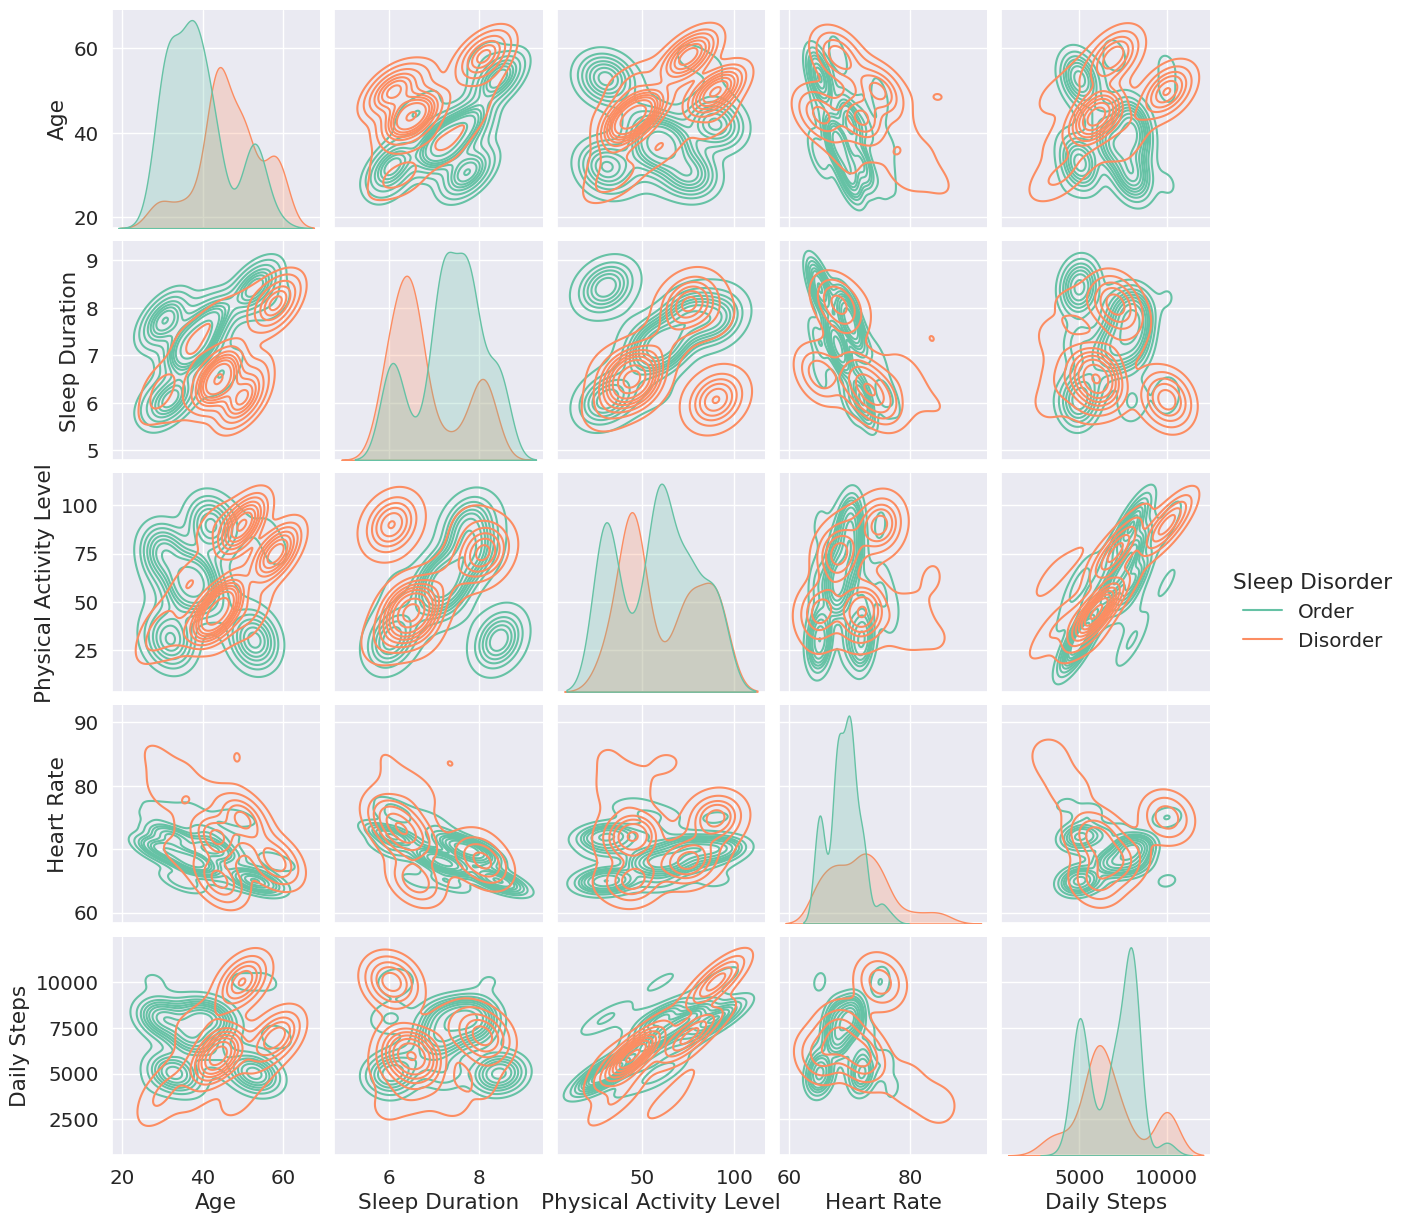

In [52]:
sns.pairplot(data, kind='kde', hue='Sleep Disorder')

Насколько сильно отличаются распределения между классами? Есть ли очевидные отличия, сдвиг?

**Вывод:**

Наблюдается заметный сдвиг в продолжительности сна. Возраст также значительно изменён. При расстройствах частота сердечных сокращений явно ниже.

Оцените, по каким признакам различаются классы, степень различия (сдвиг) и доверительный интервал сдвига. В качестве доверительного интервала используйте бутстрепный квантильный. Объясните выбор статистического теста.

*Подсказка*: выбирая статистический тест и интерпретируя результаты, помните о нулевой гипотезе и мощности. Например, немного об этом в контексте АВ тестов можно почитать [здесь](https://https://habr.com/ru/companies/avito/articles/709596/).

In [56]:
def shift(x, y):
    '''
    Вычисление оценки параметра сдвига из критерия ранговых сумм Уилкоксона
    '''

    W = [y[j] - x[i] for i in range(len(x)) for j in range(len(y))]
    return np.median(W)

def estimator(sample, axis=0):
    return np.median(sample, axis=axis)

def bootstrap(sample, B=10_000):
    '''
    Реализует процедуру бутстрепа.

    :param sample: исходная выборка, по которой будут вычисляться бутстрепные оценки
    :param B: число бутстрепных оценок
    :return: возвращает массив длины B c бутстрепными оценками
    '''

    n = len(sample)  # длина выборки
    b_samples = np.random.choice(sample, size=(B, n), replace=True)
    b_stats = estimator(b_samples, axis=1)
    return b_stats

def boostrap_quantile_confidence_interval(sample, alpha=0.95):
    '''
    Вычисляет бутстрепный доверительный интервал для квантиля.

    :param sample: массив исходной выборки
    :param alpha: уровень доверия (по умолчанию 0.95)
    :return: кортеж с нижней и верхней границами доверительного интервала, округлёнными до 5 знаков
    '''

    bootstrap_estimations = np.sort(bootstrap(sample))
    B = 10_000
    up_ind = np.ceil(B * (1 + alpha) / 2).astype('int32')
    down_ind = int(B * (1 - alpha) / 2)
    up = bootstrap_estimations[up_ind-1]
    down = bootstrap_estimations[down_ind-1]
    return (round(down, 5), round(up, 5))

def estimation(data, target, feature, p_values, shifts, ci_lefts, ci_rights, alpha=0.05):
    '''
    Вычисление оценки параметра сдвига, бутстрепного доверительного интервала для него, а также величины p-value.

    Аргументы:
    data -- pd.DataFrame данных эксперимента
    target -- название колонки, содержащей информацию о группе (A/B)
    feature -- название колонки с переменной, по которой проводим сравнение между группами
    p_values -- массив для сохранения величины p-value
    shifts -- массив для сохранения величины параметра сдвига
    ci_lefts -- массив для сохранения величины левой границы доверительного интервала
    ci_rights -- массив для сохранения величины правой границы доверительного интервала
    alpha -- уровень значимости
    '''

    x = feature.values
    y = target.values

    p_values.append(sps.mannwhitneyu(x, y)[-1])

    shifts.append(shift(x, y))

    ci_bootst = boostrap_quantile_confidence_interval((y - x.reshape(-1, 1)).reshape(-1), alpha=0.95) # бутстрепный доверительный интервал
    ci_lefts.append(ci_bootst[0])
    ci_rights.append(ci_bootst[1])

In [57]:
p_values, shifts, ci_lefts, ci_rights = [], [], [], []
for column in tqdm(columns[:-1]):
    estimation(data, data[column][data['Sleep Disorder']=='Order'], data[column][data['Sleep Disorder']=='Disorder'],
               p_values, shifts, ci_lefts, ci_rights, alpha=0.05)

100%|██████████| 5/5 [01:20<00:00, 16.02s/it]


In [58]:
results = {'feature': columns[:-1],
           'p_value': p_values,
           'shift': shifts,
           'ci_left': ci_lefts,
           'ci_right': ci_rights}
results = pd.DataFrame(results)

In [59]:
results

,feature,p_value,shift,ci_left,ci_right
0,Age,2.998305e-18,-8.0,-8.0,-8.0
1,Sleep Duration,3.637710e-09,0.7,0.7,0.7
2,Physical Activity Level,1.687369e-01,0.0,0.0,0.0
3,Heart Rate,7.916085e-08,-2.0,-2.0,-2.0
4,Daily Steps,1.539960e-01,200.0,0.0,200.0


*Замечание.* Строго говоря, необходима поправка на множественное тестирование

Какой тест вы использовали и почему? Какие выводы можно сделать по p-value? Как доверительный интервал соотносится с этими выводами?

**Вывод:**

Для анализа использовали тест Манна-Уитни, поскольку распределения данных не похожи на нормальные, а выборки независимые (группы людей с расстройством и без него разные).  

Сдвиг выявлен для возраста, продолжительности сна и частоты сердечных сокращений. Это подтверждается крайне низкими значениями p-value и доверительными интервалами, которые полностью соответствуют оценкам сдвига.  

Для уровня физической активности как сдвиг оказался равен нулю, так и p-value > 0.05, поэтому различий не обнаружено.  

В случае Daily steps наблюдается сдвиг, однако доверительный интервал слишком широкий, а p-value > 0.05. Поэтому нулевую гипотезу в данном случае отклонить нельзя.